# 초기 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# FashionMNIST 분류 모델 만들기
* 흑/백(1) 이미지 데이터 분류
* 28x28 pixel

## 데이터 로드

In [5]:
# 데이터 전처리

MNIST_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [6]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=MNIST_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=MNIST_transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



input-data size 확인

In [7]:
# batch-size=128
train_loader128 =  DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader128 =  DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# batch-size=64
train_loader64 =  DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader64 =  DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [8]:
# 128 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images128, labels128 = next(iter(train_loader128))
images128.shape, labels128.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
# 64 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images64, labels64 = next(iter(train_loader64))
images64.shape, labels64.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

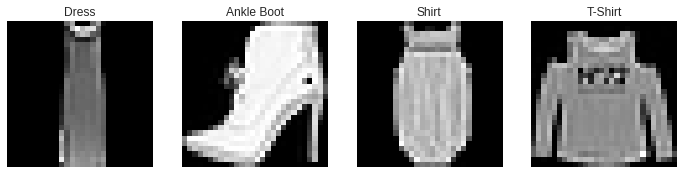

In [11]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images128[i].squeeze()
    label_idx = labels128[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## 모델 1 생성
* 10개의 convolution-layer(Conv2d)와 2개의 fully-connected(fc)로 이루어진 모델
* Total params: 28,784

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* convolution-layer 3
* convolution-layer 4
* convolution-layer 5
* convolution-layer 6
* convolution-layer 7
* convolution-layer 8
* convolution-layer 9
* maxpooling-layer
* convolution-layer 10
* flatten
* fc1
* fc2

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc2에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.
1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 16, 16, 16])
> * torch.Size([128 or 64, 19, 15, 15])
> * torch.Size([128 or 64, 29, 13, 13])
> * torch.Size([128 or 64, 29, 14, 14])
> * torch.Size([128 or 64, 6, 12, 12])
> * torch.Size([128 or 64, 2, 12, 12])
> * torch.Size([128 or 64, 10, 7, 7])
> * torch.Size([128 or 64, 20, 7, 7])
> * torch.Size([128 or 64, 20, 3, 3])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10]) 

In [12]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        # in-channels = 1 <- 흑/백
        # out-channels = 5
        # kernel_size / filter-size = 2x2 -> f=3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 28x28 -> n=28
        # (n-f+2p)/s + 1 = new n
        # (28-3+2x2)/1 + 1 = 30
        self.pool = nn.MaxPool2d(kernel_size = 2)
        # maxpool : n=30 -> 15
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        # in-channels = 5 <- 이전것의 out-channels
        # out-channels = 7
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 1
        # (n-f+2p)/s + 1 = new n    
        # (15-3+2x1)/1 + 1 = 15

        self.conv3 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=19, kernel_size=2, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=19, out_channels=29, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=29, out_channels=29, kernel_size=2, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=29, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.conv8 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.conv9 = nn.Conv2d(in_channels=2, out_channels=10, kernel_size=2, stride=2, padding=1)
        self.conv10 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=1, stride=1, padding=0)
        self.linear1 = nn.Linear(180,86)
        self.linear2 = nn.Linear(86,10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [13]:
# 모델객체 생성
DeepConv_net128 = CNN_Model1().to(device)
DeepConv_net64 = CNN_Model1().to(device)

print(DeepConv_net128)

CNN_Model1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(29, 29, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(29, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(6, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(2, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv10): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1))
  (linear1): Linear(in_features=180, out_features=86, bias=True)
  (linear2): Linear(in_features=86, out_features=10, bias=True)
)


In [14]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [15]:
output = DeepConv_net128.forward(input)
output.size()

torch.Size([128, 10])

In [16]:
summary(DeepConv_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
         MaxPool2d-2           [128, 5, 15, 15]               0
            Conv2d-3           [128, 7, 15, 15]             322
            Conv2d-4          [128, 16, 16, 16]             464
            Conv2d-5          [128, 19, 15, 15]           1,235
            Conv2d-6          [128, 29, 13, 13]           4,988
            Conv2d-7          [128, 29, 14, 14]           3,393
            Conv2d-8           [128, 6, 12, 12]           1,572
            Conv2d-9           [128, 2, 12, 12]              14
           Conv2d-10            [128, 10, 7, 7]              90
           Conv2d-11            [128, 20, 7, 7]             220
        MaxPool2d-12            [128, 20, 3, 3]               0
           Linear-13                  [128, 86]          15,566
           Linear-14                  [

In [17]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [18]:
output = DeepConv_net64.forward(input)
output.size()

torch.Size([64, 10])

In [19]:
summary(DeepConv_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
         MaxPool2d-2            [64, 5, 15, 15]               0
            Conv2d-3            [64, 7, 15, 15]             322
            Conv2d-4           [64, 16, 16, 16]             464
            Conv2d-5           [64, 19, 15, 15]           1,235
            Conv2d-6           [64, 29, 13, 13]           4,988
            Conv2d-7           [64, 29, 14, 14]           3,393
            Conv2d-8            [64, 6, 12, 12]           1,572
            Conv2d-9            [64, 2, 12, 12]              14
           Conv2d-10             [64, 10, 7, 7]              90
           Conv2d-11             [64, 20, 7, 7]             220
        MaxPool2d-12             [64, 20, 3, 3]               0
           Linear-13                   [64, 86]          15,566
           Linear-14                   

## 모델 2 생성
* 2개의 convolution-layer(Conv2d)와 5개의 fully-connected(fc)로 이루어진 모델
* Total params: 9,516,488

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* flatten
* fc1
* fc2
* fc3
* fc4
* fc5

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc5에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.

1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 1575])
> * torch.Size([128 or 64, 3000])
> * torch.Size([128 or 64, 1500])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10])

In [20]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.linear1 = nn.Linear(1575, 3000)
        self.linear2 = nn.Linear(3000, 1500)
        self.linear3 = nn.Linear(1500, 180)
        self.linear4 = nn.Linear(180, 86)
        self.linear5 = nn.Linear(86, 10)
        self.pool = nn.MaxPool2d(kernel_size = 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [21]:
# 모델객체 생성
DeepFC_net128 = CNN_Model2().to(device)
DeepFC_net64 = CNN_Model2().to(device)

print(DeepFC_net128)

CNN_Model2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1575, out_features=3000, bias=True)
  (linear2): Linear(in_features=3000, out_features=1500, bias=True)
  (linear3): Linear(in_features=1500, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=86, bias=True)
  (linear5): Linear(in_features=86, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [22]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [23]:
output = DeepFC_net128.forward(input)
output.size()

torch.Size([128, 10])

In [24]:
summary(DeepFC_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
         MaxPool2d-2           [128, 5, 15, 15]               0
            Conv2d-3           [128, 7, 15, 15]             322
            Linear-4                [128, 3000]       4,728,000
            Linear-5                [128, 1500]       4,501,500
            Linear-6                 [128, 180]         270,180
            Linear-7                  [128, 86]          15,566
            Linear-8                  [128, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 11.70
Params size (MB): 36.30
Estimated Total Size (MB): 48.38
----------------------------------------------------------------


In [25]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [26]:
output = DeepFC_net64.forward(input)
output.size()

torch.Size([64, 10])

In [27]:
summary(DeepFC_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
         MaxPool2d-2            [64, 5, 15, 15]               0
            Conv2d-3            [64, 7, 15, 15]             322
            Linear-4                 [64, 3000]       4,728,000
            Linear-5                 [64, 1500]       4,501,500
            Linear-6                  [64, 180]         270,180
            Linear-7                   [64, 86]          15,566
            Linear-8                   [64, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.85
Params size (MB): 36.30
Estimated Total Size (MB): 42.34
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [28]:
criterion = nn.CrossEntropyLoss()

optimizerDC_128 = optim.SGD(DeepConv_net128.parameters(), lr=0.001, momentum=0.9)
optimizerDC_64 = optim.SGD(DeepConv_net64.parameters(), lr=0.001, momentum=0.9)
optimizerFC_128 = optim.SGD(DeepFC_net128.parameters(), lr=0.001, momentum=0.9)
optimizerFC_64 = optim.SGD(DeepFC_net64.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

### 1. DeepConv_net128
* 10개의 Convolution-layer & 2개의 fc-layer
* 128 batch-size

In [29]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518788373470307
Epoch: 1, Iter: 200, Loss: 0.11514985680580139
Epoch: 1, Iter: 300, Loss: 0.1151550223827362
Epoch: 1, Iter: 400, Loss: 0.11513515794277192
Epoch: 2, Iter: 100, Loss: 0.11513950300216674
Epoch: 2, Iter: 200, Loss: 0.11514070355892181
Epoch: 2, Iter: 300, Loss: 0.11513252425193786
Epoch: 2, Iter: 400, Loss: 0.11513542461395264
Epoch: 3, Iter: 100, Loss: 0.11513386368751526
Epoch: 3, Iter: 200, Loss: 0.11513194513320923
Epoch: 3, Iter: 300, Loss: 0.11513042783737183
Epoch: 3, Iter: 400, Loss: 0.11513351798057556
Epoch: 4, Iter: 100, Loss: 0.11512896525859832
Epoch: 4, Iter: 200, Loss: 0.11512817847728729
Epoch: 4, Iter: 300, Loss: 0.11513785648345948
Epoch: 4, Iter: 400, Loss: 0.11513116657733917
Epoch: 5, Iter: 100, Loss: 0.11512845885753632
Epoch: 5, Iter: 200, Loss: 0.11513128352165222
Epoch: 5, Iter: 300, Loss: 0.115128875374794
Epoch: 5, Iter: 400, Loss: 0.11513585734367371
Epoch: 6, Iter: 100, Loss: 0.11513073480129242
Epoch: 6, Iter: 

In [30]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11512954795360565
Epoch: 1, Iter: 200, Loss: 0.11512991321086884
Epoch: 1, Iter: 300, Loss: 0.11513511765003204
Epoch: 1, Iter: 400, Loss: 0.11513089203834534
Epoch: 2, Iter: 100, Loss: 0.11513048672676086
Epoch: 2, Iter: 200, Loss: 0.11513395833969116
Epoch: 2, Iter: 300, Loss: 0.11513048648834229
Epoch: 2, Iter: 400, Loss: 0.11513262486457825
Epoch: 3, Iter: 100, Loss: 0.11513020050525666
Epoch: 3, Iter: 200, Loss: 0.11513073444366455
Epoch: 3, Iter: 300, Loss: 0.11513423097133636
Epoch: 3, Iter: 400, Loss: 0.11513063645362855
Epoch: 4, Iter: 100, Loss: 0.11513117587566375
Epoch: 4, Iter: 200, Loss: 0.11513061797618866
Epoch: 4, Iter: 300, Loss: 0.11513300204277038
Epoch: 4, Iter: 400, Loss: 0.11513151586055756
Epoch: 5, Iter: 100, Loss: 0.11512995374202728
Epoch: 5, Iter: 200, Loss: 0.11512670958042145
Epoch: 5, Iter: 300, Loss: 0.11513104939460754
Epoch: 5, Iter: 400, Loss: 0.1151394259929657


### 2. DeepConv_net64
* 10개의 Convolution-layer & 2개의 fc-layer
* 64 batch-size

In [31]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11516848838329315
Epoch: 1, Iter: 200, Loss: 0.11514895033836364
Epoch: 1, Iter: 300, Loss: 0.11514433634281158
Epoch: 1, Iter: 400, Loss: 0.11514841663837433
Epoch: 1, Iter: 500, Loss: 0.11515800058841705
Epoch: 1, Iter: 600, Loss: 0.11515996980667115
Epoch: 1, Iter: 700, Loss: 0.11513011610507964
Epoch: 1, Iter: 800, Loss: 0.11514438307285309
Epoch: 1, Iter: 900, Loss: 0.11514095222949981
Epoch: 2, Iter: 100, Loss: 0.11514190673828124
Epoch: 2, Iter: 200, Loss: 0.11513743698596954
Epoch: 2, Iter: 300, Loss: 0.11513503110408783
Epoch: 2, Iter: 400, Loss: 0.11513128542900085
Epoch: 2, Iter: 500, Loss: 0.11513710820674897
Epoch: 2, Iter: 600, Loss: 0.1151339007616043
Epoch: 2, Iter: 700, Loss: 0.11513183689117432
Epoch: 2, Iter: 800, Loss: 0.11513708448410034
Epoch: 2, Iter: 900, Loss: 0.11513729250431061
Epoch: 3, Iter: 100, Loss: 0.11512680852413178
Epoch: 3, Iter: 200, Loss: 0.11513844728469849
Epoch: 3, Iter: 300, Loss: 0.11513277161121369
Epoch: 3, Iter

### 3. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 128 batch-size

In [32]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11521589803695678
Epoch: 1, Iter: 200, Loss: 0.11512832510471344
Epoch: 1, Iter: 300, Loss: 0.11510522127151489
Epoch: 1, Iter: 400, Loss: 0.11502140963077545
Epoch: 2, Iter: 100, Loss: 0.11481351518630982
Epoch: 2, Iter: 200, Loss: 0.11462688148021698
Epoch: 2, Iter: 300, Loss: 0.11423938310146332
Epoch: 2, Iter: 400, Loss: 0.11332581567764283
Epoch: 3, Iter: 100, Loss: 0.09964721465110779
Epoch: 3, Iter: 200, Loss: 0.07160327166318893
Epoch: 3, Iter: 300, Loss: 0.04855089735984802
Epoch: 3, Iter: 400, Loss: 0.04089414682984352
Epoch: 4, Iter: 100, Loss: 0.03428824037313461
Epoch: 4, Iter: 200, Loss: 0.03300391402840614
Epoch: 4, Iter: 300, Loss: 0.03283174738287926
Epoch: 4, Iter: 400, Loss: 0.03138311889767647
Epoch: 5, Iter: 100, Loss: 0.03132672920823097
Epoch: 5, Iter: 200, Loss: 0.029827597305178644
Epoch: 5, Iter: 300, Loss: 0.029282889738678933
Epoch: 5, Iter: 400, Loss: 0.028606348782777787
Epoch: 6, Iter: 100, Loss: 0.028053766176104545
Epoch: 6,

### 4. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 64 batch-size

In [33]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11515967524051667
Epoch: 1, Iter: 200, Loss: 0.11504141676425934
Epoch: 1, Iter: 300, Loss: 0.11485185503959655
Epoch: 1, Iter: 400, Loss: 0.11468493437767029
Epoch: 1, Iter: 500, Loss: 0.11431456041336059
Epoch: 1, Iter: 600, Loss: 0.11368034052848816
Epoch: 1, Iter: 700, Loss: 0.11210923361778259
Epoch: 1, Iter: 800, Loss: 0.10531451910734177
Epoch: 1, Iter: 900, Loss: 0.07428441032767295
Epoch: 2, Iter: 100, Loss: 0.04465720424056053
Epoch: 2, Iter: 200, Loss: 0.03938972008228302
Epoch: 2, Iter: 300, Loss: 0.03609034276008606
Epoch: 2, Iter: 400, Loss: 0.0344801963865757
Epoch: 2, Iter: 500, Loss: 0.03300356136262417
Epoch: 2, Iter: 600, Loss: 0.03328918868303299
Epoch: 2, Iter: 700, Loss: 0.03174122843146324
Epoch: 2, Iter: 800, Loss: 0.03069165089726448
Epoch: 2, Iter: 900, Loss: 0.031170191943645478
Epoch: 3, Iter: 100, Loss: 0.030182662352919578
Epoch: 3, Iter: 200, Loss: 0.02809500402212143
Epoch: 3, Iter: 300, Loss: 0.028851626008749007
Epoch: 3, I

## 모델 테스트

In [34]:
# 전체 test 데이터에 대해서 성능 확인

correct_list = [0]*4
total_list = [0]*4
a = -1

model_list = {'DeepConv' : [DeepConv_net128, DeepConv_net64],
              'DeepFC' : [DeepFC_net128, DeepFC_net64]}
data_list = [test_loader128, test_loader64]

with torch.no_grad(): # grad가 필요없다.

    for key in model_list:
        for idx in range(len(model_list[key])):
            a += 1
            model = model_list[key][idx]
            data_loader = data_list[idx]
            for data in data_loader:
                images, labels = data[0].to(device), data[1].to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_list[a] += labels.size(0)
                correct_list[a] += (predicted == labels).sum().item()
            
correct_rate = np.array(correct_list) / np.array(total_list)
model_name = ['DeepConv_net128', 'DeepConv_net64', 'DeepFC_net128', 'DeepFC_net64']

for i in range(len(correct_rate)):
    print('{0} : {1}'.format(model_name[i], correct_rate[i]))

DeepConv_net128 : 0.1
DeepConv_net64 : 0.1
DeepFC_net128 : 0.8268
DeepFC_net64 : 0.8614


# FashionMNIST 분류 모델 중 성능이 낮은 모델 이유 확인

## Convolution-layer를 하나씩 추가하면서, 성능변화를 관찰

### 3개의 convolution-layer 사용시

In [35]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)

        self.fc1 = nn.Linear(16* 16 * 16, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [36]:
# 모델객체 생성
new_model = CNN_Model3().to(device)

print(new_model)

CNN_Model3(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [37]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Linear-4                [128, 3000]      12,291,000
            Linear-5                [128, 1500]       4,501,500
            Linear-6                 [128, 180]         270,180
            Linear-7                  [128, 86]          15,566
            Linear-8                  [128, 10]             870
Total params: 17,079,952
Trainable params: 17,079,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 14.60
Params size (MB): 65.15
Estimated Total Size (MB): 80.13
----------------------------------------------------------------


In [38]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [39]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11519797706604004
Epoch: 1, Iter: 200, Loss: 0.11522237825393676
Epoch: 1, Iter: 300, Loss: 0.11516662573814392
Epoch: 1, Iter: 400, Loss: 0.1151015408039093
Epoch: 2, Iter: 100, Loss: 0.11514464938640595
Epoch: 2, Iter: 200, Loss: 0.11507028007507324
Epoch: 2, Iter: 300, Loss: 0.1150740852355957
Epoch: 2, Iter: 400, Loss: 0.11505231046676635
Epoch: 3, Iter: 100, Loss: 0.11503847599029542
Epoch: 3, Iter: 200, Loss: 0.1150178611278534
Epoch: 3, Iter: 300, Loss: 0.11500108897686005
Epoch: 3, Iter: 400, Loss: 0.11497830772399903
Epoch: 4, Iter: 100, Loss: 0.11493879497051239
Epoch: 4, Iter: 200, Loss: 0.11490023088455201
Epoch: 4, Iter: 300, Loss: 0.11485231828689575
Epoch: 4, Iter: 400, Loss: 0.11479856669902802
Epoch: 5, Iter: 100, Loss: 0.1146689305305481
Epoch: 5, Iter: 200, Loss: 0.1145541776418686
Epoch: 5, Iter: 300, Loss: 0.11439051496982575
Epoch: 5, Iter: 400, Loss: 0.11414401769638062
Epoch: 6, Iter: 100, Loss: 0.11334704291820526
Epoch: 6, Iter: 20

In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

79.61


### 4개의 convolution-layer 사용시

In [41]:
class CNN_Model4(nn.Module):
    def __init__(self):
        super(CNN_Model4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)

        self.fc1 = nn.Linear(15* 15 * 19, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [42]:
# 모델객체 생성
new_model = CNN_Model4().to(device)

print(new_model)

CNN_Model4(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=4275, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [43]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Linear-5                [128, 3000]      12,828,000
            Linear-6                [128, 1500]       4,501,500
            Linear-7                 [128, 180]         270,180
            Linear-8                  [128, 86]          15,566
            Linear-9                  [128, 10]             870
Total params: 17,618,187
Trainable params: 17,618,187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.77
Params size (MB): 67.21
Estimated Total Size (MB): 86.36
----------------------------------

In [44]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [45]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11527873659133911
Epoch: 1, Iter: 200, Loss: 0.11519156944751739
Epoch: 1, Iter: 300, Loss: 0.11520723807811738
Epoch: 1, Iter: 400, Loss: 0.1151272155046463
Epoch: 2, Iter: 100, Loss: 0.11514651477336883
Epoch: 2, Iter: 200, Loss: 0.11511514616012573
Epoch: 2, Iter: 300, Loss: 0.11514718115329742
Epoch: 2, Iter: 400, Loss: 0.11511483192443847
Epoch: 3, Iter: 100, Loss: 0.11510564291477203
Epoch: 3, Iter: 200, Loss: 0.11510979640483857
Epoch: 3, Iter: 300, Loss: 0.11509927439689636
Epoch: 3, Iter: 400, Loss: 0.11509517168998719
Epoch: 4, Iter: 100, Loss: 0.11508790099620819
Epoch: 4, Iter: 200, Loss: 0.11508399474620819
Epoch: 4, Iter: 300, Loss: 0.1150684084892273
Epoch: 4, Iter: 400, Loss: 0.11506469023227692
Epoch: 5, Iter: 100, Loss: 0.11504921841621399
Epoch: 5, Iter: 200, Loss: 0.11503863394260407
Epoch: 5, Iter: 300, Loss: 0.1150311074256897
Epoch: 5, Iter: 400, Loss: 0.11501756119728089
Epoch: 6, Iter: 100, Loss: 0.11498398780822754
Epoch: 6, Iter: 

In [46]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

77.78


### 5개의 convolution-layer 사용시

In [47]:
class CNN_Model5(nn.Module):
    def __init__(self):
        super(CNN_Model5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)      
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19, 29, 3)

        self.fc1 = nn.Linear(29 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [48]:
# 모델객체 생성
new_model = CNN_Model5().to(device)

print(new_model)

CNN_Model5(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4901, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=10, bias=True)
)


In [49]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Linear-6                 [128, 100]         490,200
            Linear-7                  [128, 50]           5,050
            Linear-8                  [128, 25]           1,275
            Linear-9                  [128, 10]             260
Total params: 503,844
Trainable params: 503,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 19.07
Params size (MB): 1.92
Estimated Total Size (MB): 21.38
-----------------------------------------

In [50]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [51]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11549218165874481
Epoch: 1, Iter: 200, Loss: 0.11540740072727203
Epoch: 1, Iter: 300, Loss: 0.1152387079000473
Epoch: 1, Iter: 400, Loss: 0.1153241205215454
Epoch: 2, Iter: 100, Loss: 0.11521904492378235
Epoch: 2, Iter: 200, Loss: 0.11521460092067719
Epoch: 2, Iter: 300, Loss: 0.11515760707855224
Epoch: 2, Iter: 400, Loss: 0.11515409243106842
Epoch: 3, Iter: 100, Loss: 0.11515821385383605
Epoch: 3, Iter: 200, Loss: 0.11514679312705994
Epoch: 3, Iter: 300, Loss: 0.11513412463665008
Epoch: 3, Iter: 400, Loss: 0.11513094508647918
Epoch: 4, Iter: 100, Loss: 0.11514103591442108
Epoch: 4, Iter: 200, Loss: 0.11512250947952271
Epoch: 4, Iter: 300, Loss: 0.11512770676612855
Epoch: 4, Iter: 400, Loss: 0.11512424969673157
Epoch: 5, Iter: 100, Loss: 0.11512084066867828
Epoch: 5, Iter: 200, Loss: 0.11512089943885803
Epoch: 5, Iter: 300, Loss: 0.11511798524856567
Epoch: 5, Iter: 400, Loss: 0.11511984932422638
Epoch: 6, Iter: 100, Loss: 0.11511286628246307
Epoch: 6, Iter:

In [52]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

28.16
